In [352]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from matplotlib.colors import ListedColormap
from matplotlib.dates import MonthLocator
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SS
from sklearn.linear_model import LinearRegression as LinearRegression, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance

This notebook is a look into feature importance of the convoy data. PCA Analysis, Random Forest Classifier feature importance, and Gradient Boosting Classifier feature importance are performed.


In [353]:
df = pd.read_csv('Complete_Convoy_Data.csv')
df = df.drop(columns=['Unnamed: 0'])

In [354]:
df2 = df[df['Time At Sea (Days)'] > 10]
df2 = df2.drop(columns=['Convoy Number', 'Number of Ships Sunk', 'Depart_Date', 'Arrival/Dispersal Date', 'Number of Escorts Sunk', \
                         'Number of Stragglers Sunk', 'Total Tons of Ships Sunk', 'Escort Sink Percentage', 'Straggler Sink Percentage'])
                        #Removes features that leak data or are irrelevant 
df2.reset_index(drop=True)
df2['High Risk'] = (df2['Overall Sink Percentage'] > 0).astype(int)

In [355]:
X = np.array(df2.drop(columns=['Overall Sink Percentage', 'High Risk']))
y = df2['High Risk'].values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=1945)
(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

((702, 11), (176, 11), (702,), (176,))

In [356]:
#Standard Scaler
SS = SS()

In [357]:
X_scaled = SS.fit_transform(df2.drop(columns =['High Risk', 'Overall Sink Percentage']))

In [358]:
#Preform PCA 
pca = PCA()
PCA_X= pca.fit_transform(X_scaled)
PCA_X_df = pd.DataFrame(PCA_X[:,:3], columns = ['PC1','PC2', 'PC3'])
df2.reset_index(drop=True, inplace=True)
PCA_X_df['High Risk'] = df2['High Risk']
print('PCA Explained Variance Ratio:', pca.explained_variance_ratio_)


PCA Explained Variance Ratio: [0.30715904 0.16975115 0.11653695 0.10583948 0.07846915 0.07141338
 0.06100088 0.05527786 0.02497971 0.00694364 0.00262876]


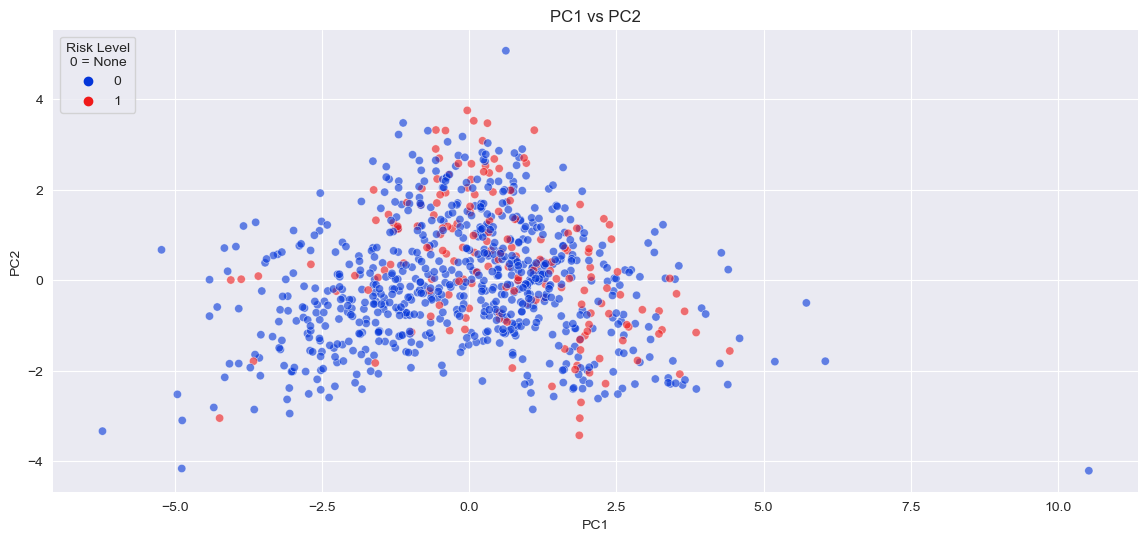

In [359]:
#PC1 vs PC2 Scatter Plot
labels = ['Low Risk', 'High Risk']
plt.figure(figsize=(14, 6))
palette = sns.color_palette(['#0436d9', '#f01a1a'])
sns.scatterplot(data=PCA_X_df, x='PC1', y='PC2', hue='High Risk', palette=palette, alpha=0.6)
sns.set_style('darkgrid')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='upper left', title='Risk Level\n 0 = None')
plt.title('PC1 vs PC2')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

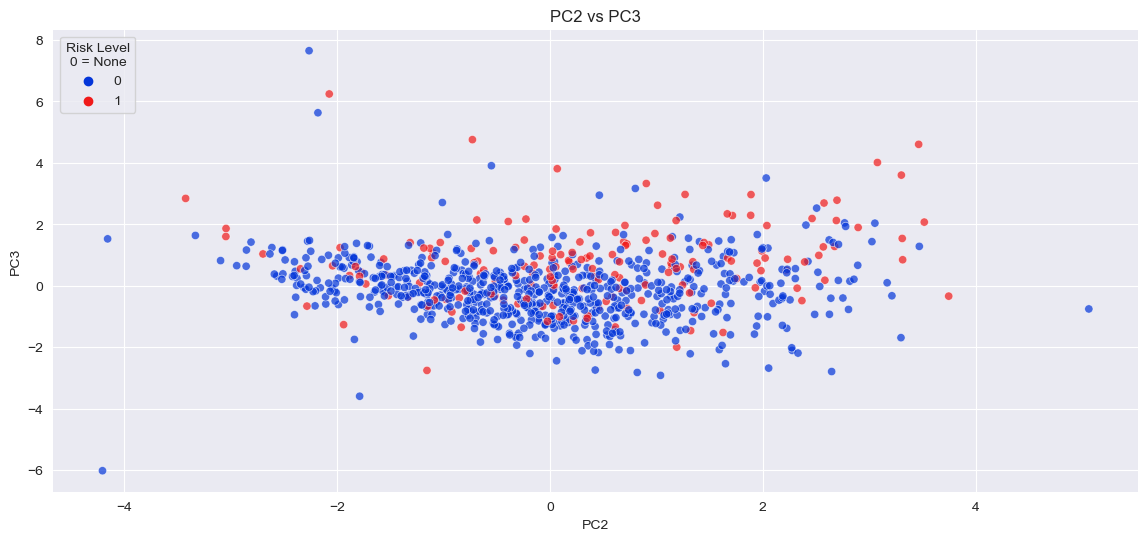

In [360]:
#PC2 vs PC3 Scatter Plot
labels = ['Low Risk', 'High Risk']
plt.figure(figsize=(14, 6))
palette = sns.color_palette(['#0436d9', '#f01a1a'])
sns.scatterplot(data=PCA_X_df, x='PC2', y='PC3', hue='High Risk', palette=palette, alpha=0.7)
sns.set_style('darkgrid')
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.legend(loc='upper left', title='Risk Level\n 0 = None')
plt.title('PC2 vs PC3')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

The PCA Scatter Plot of PC1 & PC2 does not clearly display any trends within the data. Likely the data is too complex to be effectively captured in two dimensions. (Needs Work)

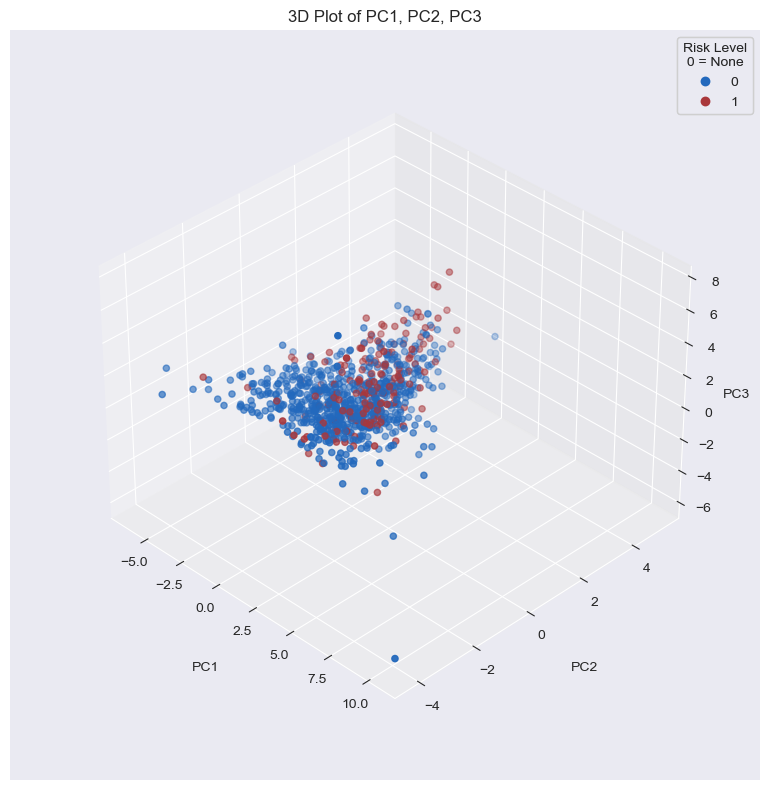

In [361]:
#3D Plot of PC1, PC2, PC3
x = PCA_X_df['PC1']
y = PCA_X_df['PC2']
z = PCA_X_df['PC3']
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect(None, zoom=0.85)
scatter = ax.scatter(PCA_X_df['PC1'], PCA_X_df['PC2'], PCA_X_df['PC3'], c=PCA_X_df['High Risk'], cmap='vlag')
ax.view_init(elev=35., azim=-45) #Changes the angle at which the plot is viewed
ax.set_xlabel('PC1', labelpad=20)
ax.set_ylabel('PC2', labelpad=20)
ax.set_zlabel('PC3', labelpad=4)
legend = ax.legend(*scatter.legend_elements(), title='Risk Level\n 0 = None')
ax.add_artist(legend)
plt.title('3D Plot of PC1, PC2, PC3')
fig.tight_layout()
plt.show()

In [362]:
PCA_X_df['High Risk'] = PCA_X_df['High Risk'].astype(str) #Change to High Risk to discrete values
fig = px.scatter_3d(PCA_X_df, x='PC1', y='PC2', z='PC3', color='High Risk', title='3D Scatter Plot of PC1, PC2, PC3',
                    color_discrete_map={'0': '#0436d9', '1': '#f01a1a'})
fig.update_layout(scene = dict(xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3'), legend_title_text='Risk Level:<br>0 = No Risk')
fig.show()                    

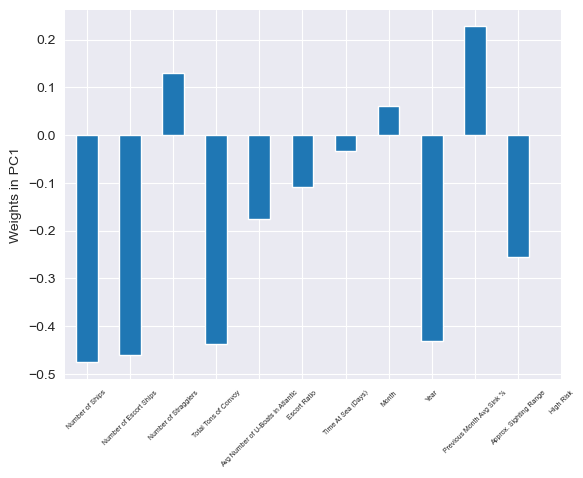

PC1 Weights:
 0    -0.476040
1    -0.461293
2     0.129192
3    -0.438515
4    -0.175448
5    -0.108506
6    -0.032910
7     0.060469
8    -0.432228
9     0.227472
10   -0.256418
dtype: float64


In [363]:
#PC1 Loading Plot
pca_component_1 = pd.Series(pca.components_[0])
pca_component_1.plot.bar()
labels = df2.drop(columns='Overall Sink Percentage').columns
plt.xticks(range(len(labels)), labels, fontsize=5, rotation=45)
plt.ylabel('Weights in PC1')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()
print('PC1 Weights:\n', pca_component_1)

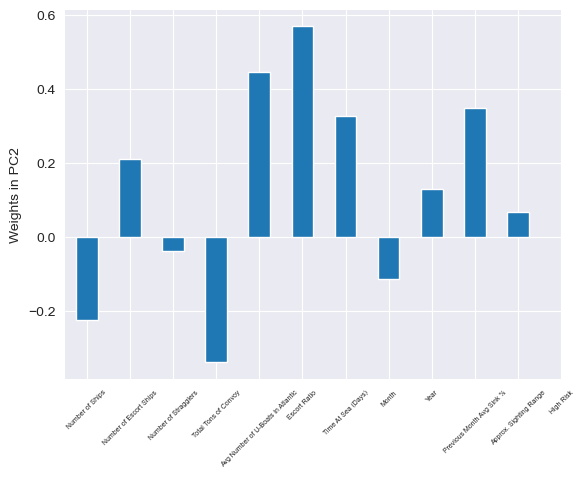

PC2 Weights:
 0    -0.224493
1     0.212486
2    -0.037722
3    -0.338435
4     0.446404
5     0.570214
6     0.329128
7    -0.112399
8     0.129654
9     0.348539
10    0.069445
dtype: float64


In [364]:
#PC2 Loading Plot
pca_component_2 = pd.Series(pca.components_[1])
pca_component_2.plot.bar()
labels = df2.drop(columns='Overall Sink Percentage').columns
plt.xticks(range(len(labels)), labels, fontsize=5, rotation=45)
plt.ylabel('Weights in PC2')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()
print('PC2 Weights:\n', pca_component_2)

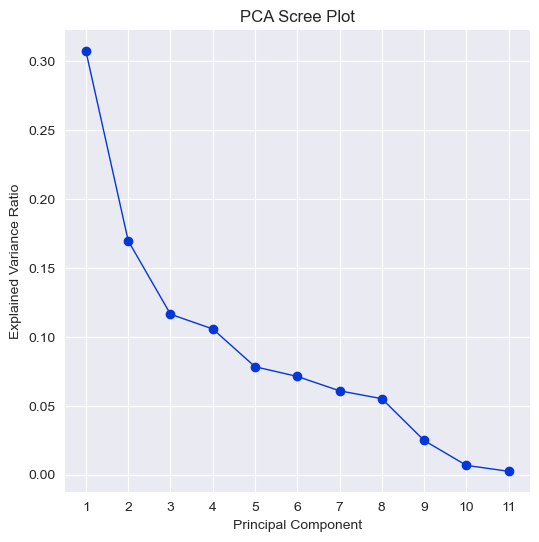

In [365]:
#PCA Scree Plot
explained_variance = pca.explained_variance_ratio_
fig = plt.figure(figsize=(6,6))
plt.plot(range(1, len(explained_variance)+1), explained_variance, 'o-', linewidth='1', color='#0436d9')
plt.title('PCA Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

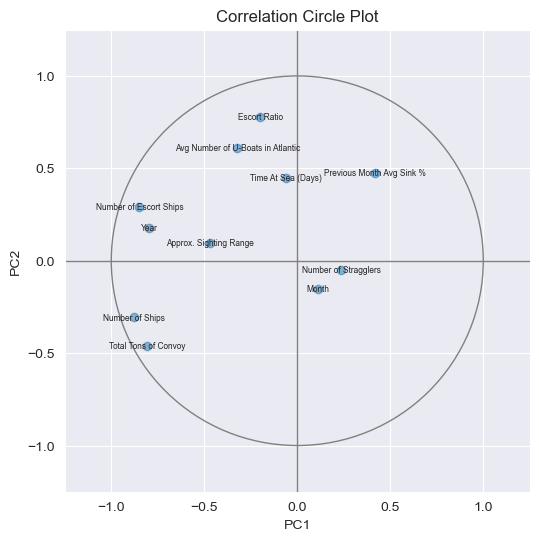

In [371]:
# PCA Correlation Circle Plot
df3 = df2.drop(columns=['Overall Sink Percentage', 'High Risk'])
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
fig = plt.figure(figsize=(6, 6))
plt.scatter(loadings[:, 0], loadings[:, 1], alpha=0.5)
for i, feature in enumerate(df3.columns):
    plt.text(loadings[i, 0], loadings[i, 1], feature, fontsize=6, ha='center', va='center')
circle = plt.Circle((0, 0), 1, color='gray', fill=False)
plt.gca().add_artist(circle)
plt.axhline(0, color='gray', lw=1)
plt.axvline(0, color='gray', lw=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Correlation Circle Plot')
plt.grid(True)
plt.xlim(-1.25, 1.25)
plt.ylim(-1.25, 1.25)
plt.show()

In [301]:
X_names = ['Number of Ships', 'Number of Escort Ships', 'Number of Stragglers', 'Total Tons of Convoy', \
           'Avg Number of U-Boats in Atlantic',	'Escort Ratio',	'Time At Sea (Days)', 'Month', 'Year', 'Previous Month Avg Sink %', \
            'Approx. Sighting Range']
y_names = ['High/Low Risk']

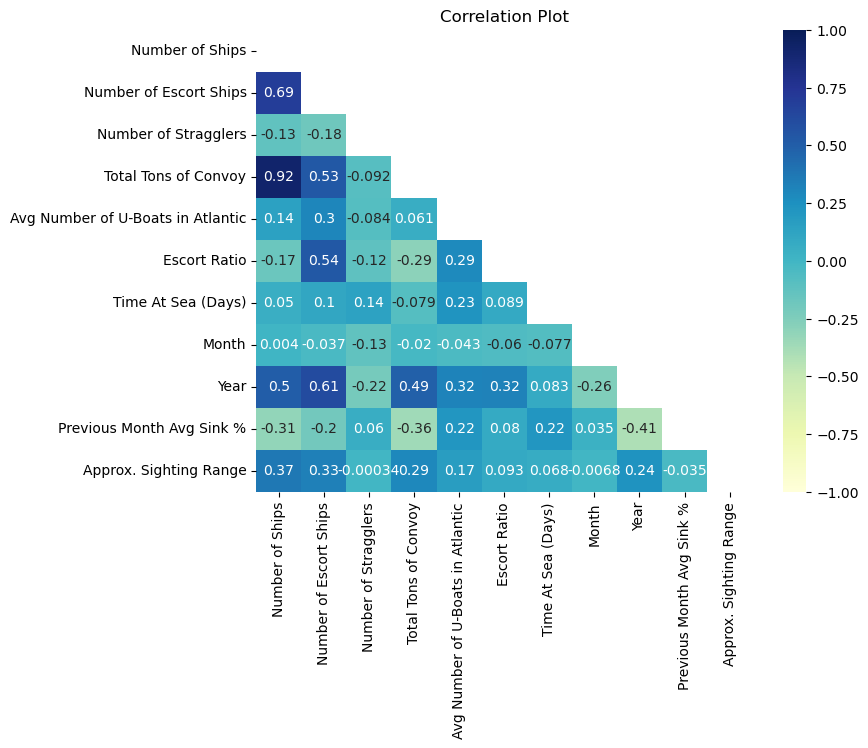

In [302]:
#Correlation Plot
plt.figure(figsize = [8,6])
X_df = pd.DataFrame(X, columns=X_names)
mask = np.triu(X_df.corr())
sns.heatmap(X_df.corr(), mask = mask, cmap='YlGnBu', vmin=-1, vmax=1, annot=True)
plt.title('Correlation Plot')
plt.show()

In [49]:
pd.DataFrame(pca.components_.T, index = X_names).sort_values(0,ascending = False)

#Needs work


,0,1
Previous Month Avg Sink %,0.210337,0.397269
Number of Stragglers,0.121810,-0.023682
Month,0.063475,-0.078087
Time At Sea (Days),-0.033484,0.352117
Escort Ratio,-0.118107,0.552308
Avg Number of U-Boats in Atlantic,-0.189632,0.433301
Approx. Sighting Range,-0.255484,0.086682
Year,-0.434894,0.096607
Total Tons of Convoy,-0.437297,-0.333664
Number of Escort Ships,-0.460025,0.215052


In [48]:
pd.DataFrame(pca.components_.T, index = X_names).sort_values(1,ascending = False)

#Needs work

,0,1
Escort Ratio,-0.118107,0.552308
Avg Number of U-Boats in Atlantic,-0.189632,0.433301
Previous Month Avg Sink %,0.210337,0.397269
Time At Sea (Days),-0.033484,0.352117
Number of Escort Ships,-0.460025,0.215052
Year,-0.434894,0.096607
Approx. Sighting Range,-0.255484,0.086682
Number of Stragglers,0.121810,-0.023682
Month,0.063475,-0.078087
Number of Ships,-0.478126,-0.210507


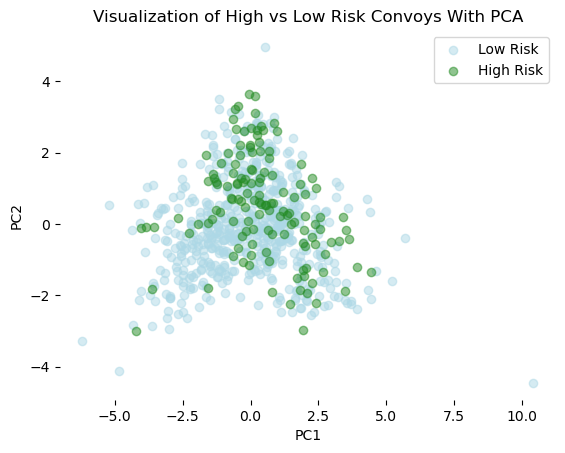

In [50]:


y_names_2 = ['Low Risk', 'High Risk']
colors = ['lightblue','forestgreen']
for yi in [0,1]:
    idx = ytrain == yi
    plt.scatter(pca_X[idx,0],pca_X[idx,1], label = y_names_2[yi], color = colors[yi], alpha = 0.5)
plt.legend(loc='upper right')
plt.title('Visualization of High vs Low Risk Convoys With PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()


#Needs Work, Same as pc1 vs pc2 plot above

Feature Analysis For Random Forest Classifier:

In [20]:
#Grid Search For Random Forest Classifier Params
param_grid = dict(n_estimators=[50, 100, 200, 300, 400, 500], max_features=['sqrt', 0.5, 'log2'], min_samples_split=[2, 3, 4, 5, 10, 15, 20]) #Params to test
cv = KFold(n_splits=10, random_state=1945, shuffle=True)
grid = GridSearchCV(RFC(), param_grid=param_grid, cv=cv, scoring='accuracy')
grid.fit(Xtrain, ytrain)

GridSearchCV(cv=KFold(n_splits=10, random_state=1945, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_features': ['sqrt', 0.5, 'log2'],
                         'min_samples_split': [2, 3, 4, 5, 10, 15, 20],
                         'n_estimators': [50, 100, 200, 300, 400, 500]},
             scoring='accuracy')

In [21]:
print(f'The best parameters are {grid.best_params_} with a score of {grid.best_score_:.2f}')

The best parameters are {'max_features': 'sqrt', 'min_samples_split': 20, 'n_estimators': 200} with a score of 0.85


In [22]:
pd.DataFrame(grid.cv_results_)[['param_n_estimators','param_max_features','param_min_samples_split','mean_test_score','rank_test_score']]

,param_n_estimators,param_max_features,param_min_samples_split,mean_test_score,rank_test_score
0,50,sqrt,2,0.834648,89
1,100,sqrt,2,0.824668,124
2,200,sqrt,2,0.836076,82
3,300,sqrt,2,0.837505,61
4,400,sqrt,2,0.837505,61
...,...,...,...,...,...
121,100,log2,20,0.841791,31
122,200,log2,20,0.844628,14
123,300,log2,20,0.841771,39
124,400,log2,20,0.846056,8


In [23]:
Random_Forest_Classifier = RFC(max_features='log2', min_samples_split=20, n_estimators=100, random_state=1945) #Using optimized params
Random_Forest_Classifier.fit(Xtrain, ytrain)
ypredict = Random_Forest_Classifier.predict(Xtest)
Ran_For_mse = mean_squared_error(ytest, ypredict)
Classification_Report = classification_report(ytest, ypredict)
print('Random Forest Train Score (Mean Accuracy):', Random_Forest_Classifier.score(Xtrain, ytrain))
print('Random Forest Test Score (Mean Accuracy):', Random_Forest_Classifier.score(Xtest, ytest))
print('Random Forest Mean Squared Error', Ran_For_mse)
print('Random Forest Classifier Report: \n', Classification_Report)

Random Forest Train Score (Mean Accuracy): 0.896011396011396
Random Forest Test Score (Mean Accuracy): 0.8579545454545454
Random Forest Mean Squared Error 0.14204545454545456
Random Forest Classifier Report: 
               precision    recall  f1-score   support

           0       0.87      0.96      0.92       141
           1       0.75      0.43      0.55        35

    accuracy                           0.86       176
   macro avg       0.81      0.70      0.73       176
weighted avg       0.85      0.86      0.84       176



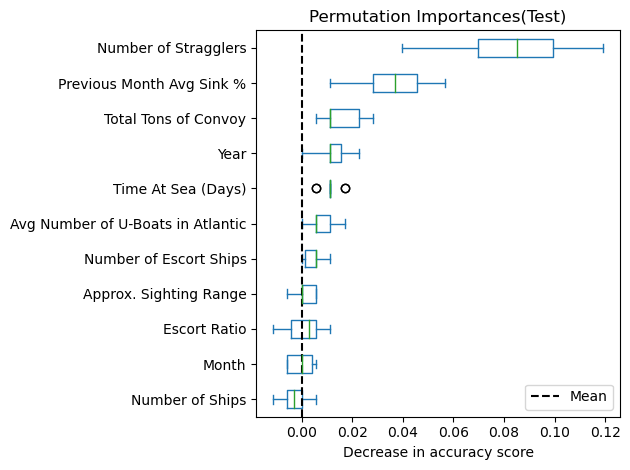

In [24]:
result = permutation_importance(Random_Forest_Classifier, Xtest, ytest, n_repeats=10, random_state=1945, n_jobs=2)
X_df = pd.DataFrame(Xtest, columns = X_names)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sorted_importances_idx].T, columns=X_df.columns[sorted_importances_idx])
ax = importances.plot.box(vert=False, whis=10)
ax.set_title('Permutation Importances(Test)')
ax.axvline(x=0, color='k', linestyle='--', label='Mean')
ax.set_xlabel('Decrease in accuracy score')
plt.legend()
ax.figure.tight_layout()

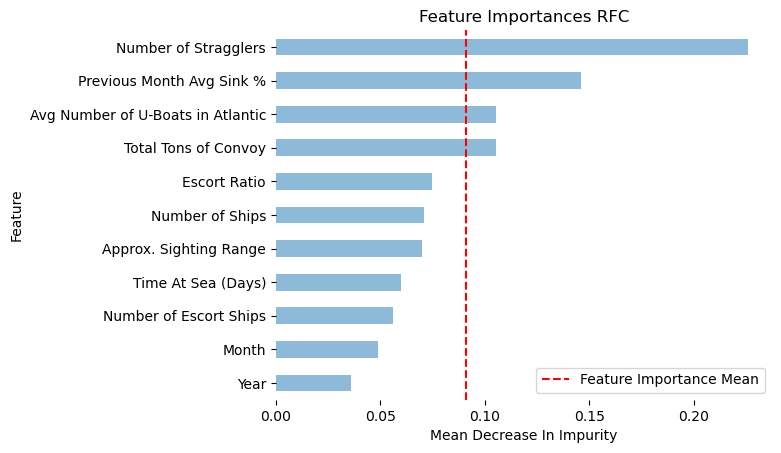

In [25]:
forest_importances = pd.Series(Random_Forest_Classifier.feature_importances_,  X_names)
filtered = forest_importances[forest_importances > 0].sort_values()[-15:]
fig, ax = plt.subplots()
filtered.plot.barh(ax=ax, alpha = 0.5, label='_nolegend_')
plt.axvline(forest_importances.mean(), c='red', linestyle ='--', label='Feature Importance Mean')
ax.set_title('Feature Importances RFC')
ax.set_ylabel('Feature')
ax.set_xlabel('Mean Decrease In Impurity')
[ax.spines[i].set_visible(False) for i in ax.spines]
plt.legend(loc='lower right')
plt.show()

Optimal number of features: 9


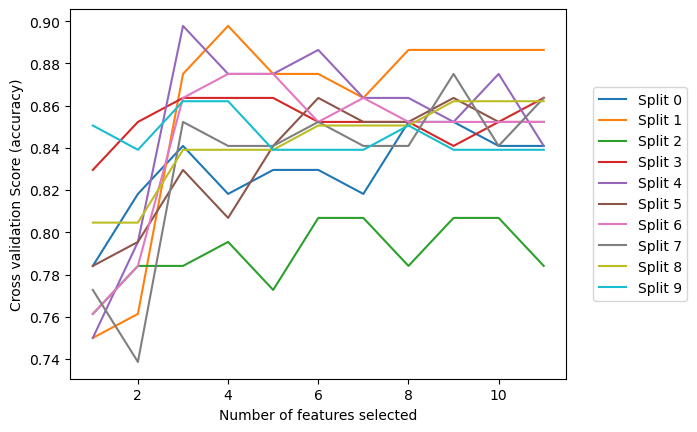

In [26]:
#RFECV
Random_Forest_Classifier = RFC(max_features='log2', min_samples_split=20, n_estimators=100, oob_score=True, random_state=1945) #Same params as before
min_features_to_select = 1 
rfecv = RFECV(estimator=Random_Forest_Classifier, step=1, cv=KFold(n_splits=10, random_state=1945, shuffle = True), \
    scoring='accuracy', min_features_to_select=min_features_to_select,)
rfecv.fit(X, y)
print('Optimal number of features: %d' % rfecv.n_features_)
#Plot
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation Score (accuracy)')
n_splits = 10 
for i in range(n_splits):
    split_score_label = f'split{i}_test_score'
    if split_score_label in rfecv.cv_results_:
        split_scores = rfecv.cv_results_[split_score_label]
        plt.plot(range(min_features_to_select, len(split_scores) + min_features_to_select), split_scores, label=f'Split {i}')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left')
plt.show()

In [27]:
print('RFECV Score:',rfecv.score(X, y))

RFECV Score: 0.8997722095671982


In [28]:
print('Feature Rankings:\n')
print(pd.Series(rfecv.ranking_, X_names).sort_values())

Feature Rankings:

Number of Ships                      1
Number of Escort Ships               1
Number of Stragglers                 1
Total Tons of Convoy                 1
Avg Number of U-Boats in Atlantic    1
Escort Ratio                         1
Time At Sea (Days)                   1
Previous Month Avg Sink %            1
Approx. Sighting Range               1
Year                                 2
Month                                3
dtype: int64


Feature Analysis For Gradient Boosting Classifier:

In [29]:
param_grid_2 = dict(n_estimators=[50, 100, 200, 300, 400, 500], max_features=['sqrt', 0.5, 'log2'], min_samples_split=[2, 5, 10, 15, 20],  
                  max_depth=[1, 3, 5]) #Params to test
cv_2 = KFold(n_splits=10, random_state=1945, shuffle = True)
grid_2 = GridSearchCV(GBC(), param_grid=param_grid_2, cv=cv_2, scoring='accuracy')
grid_2.fit(Xtrain, ytrain)

GridSearchCV(cv=KFold(n_splits=10, random_state=1945, shuffle=True),
             estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [1, 3, 5],
                         'max_features': ['sqrt', 0.5, 'log2'],
                         'min_samples_split': [2, 5, 10, 15, 20],
                         'n_estimators': [50, 100, 200, 300, 400, 500]},
             scoring='accuracy')

In [30]:
print(f'The best parameters are {grid_2.best_params_} with a score of {grid_2.best_score_:.2f}')

The best parameters are {'max_depth': 1, 'max_features': 'log2', 'min_samples_split': 20, 'n_estimators': 300} with a score of 0.85


In [31]:
pd.DataFrame(grid_2.cv_results_)[['param_n_estimators','param_max_features','param_min_samples_split', 'param_max_depth', 'mean_test_score','rank_test_score']]

,param_n_estimators,param_max_features,param_min_samples_split,param_max_depth,mean_test_score,rank_test_score
0,50,sqrt,2,1,0.824688,188
1,100,sqrt,2,1,0.837485,87
2,200,sqrt,2,1,0.843239,44
3,300,sqrt,2,1,0.846117,8
4,400,sqrt,2,1,0.843280,35
...,...,...,...,...,...,...
265,100,log2,20,5,0.824748,177
266,200,log2,20,5,0.827565,154
267,300,log2,20,5,0.820503,233
268,400,log2,20,5,0.820503,233


In [32]:
Gradien_Boosting_Classifier = GBC(max_features='log2', min_samples_split=10, n_estimators=50, max_depth=3, random_state=1945) #Using optimized params
Gradien_Boosting_Classifier.fit(Xtrain, ytrain)
ypredict = Gradien_Boosting_Classifier.predict(Xtest)
GBC_mse = mean_squared_error(ytest, ypredict)
Classification_Report_2 = classification_report(ytest, ypredict)
print('Random Forest Train Score (Mean Accuracy):', Gradien_Boosting_Classifier.score(Xtrain, ytrain))
print('Random Forest Test Score (Mean Accuracy):', Gradien_Boosting_Classifier.score(Xtest, ytest))
print('Random Forest Mean Squared Error', GBC_mse)
print('Random Forest Classifier Report: \n', Classification_Report_2)

Random Forest Train Score (Mean Accuracy): 0.905982905982906
Random Forest Test Score (Mean Accuracy): 0.8579545454545454
Random Forest Mean Squared Error 0.14204545454545456
Random Forest Classifier Report: 
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       141
           1       0.73      0.46      0.56        35

    accuracy                           0.86       176
   macro avg       0.80      0.71      0.74       176
weighted avg       0.85      0.86      0.84       176



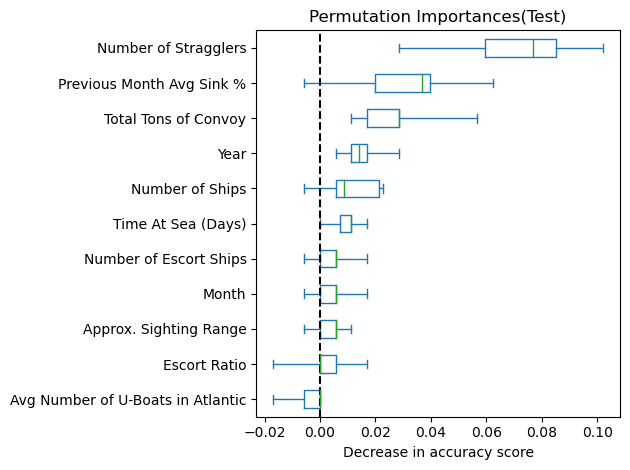

In [33]:
result = permutation_importance(Gradien_Boosting_Classifier, Xtest, ytest, n_repeats=10, random_state=1945, n_jobs=2)
X_df = pd.DataFrame(Xtest, columns = X_names)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(result.importances[sorted_importances_idx].T, columns=X_df.columns[sorted_importances_idx])
ax = importances.plot.box(vert=False, whis=10)
ax.set_title('Permutation Importances(Test)')
ax.axvline(x=0, color='k', linestyle='--')
ax.set_xlabel('Decrease in accuracy score')
ax.figure.tight_layout()

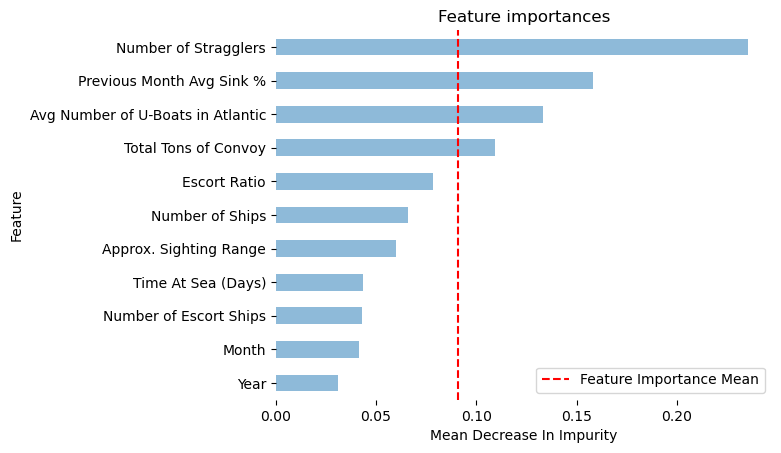

In [34]:
GBC_importances = pd.Series(Gradien_Boosting_Classifier.feature_importances_, X_names)
filtered = GBC_importances[GBC_importances > 0].sort_values()[-15:]
fig, ax = plt.subplots()
filtered.plot.barh(ax=ax, alpha = 0.5, label='_nolegend_')
plt.axvline(GBC_importances.mean(), c='red', linestyle ='--', label='Feature Importance Mean')
ax.set_title('Feature importances')
ax.set_ylabel('Feature')
ax.set_xlabel('Mean Decrease In Impurity')
[ax.spines[i].set_visible(False) for i in ax.spines]
plt.legend(loc='lower right')
plt.show()

Optimal number of features: 9


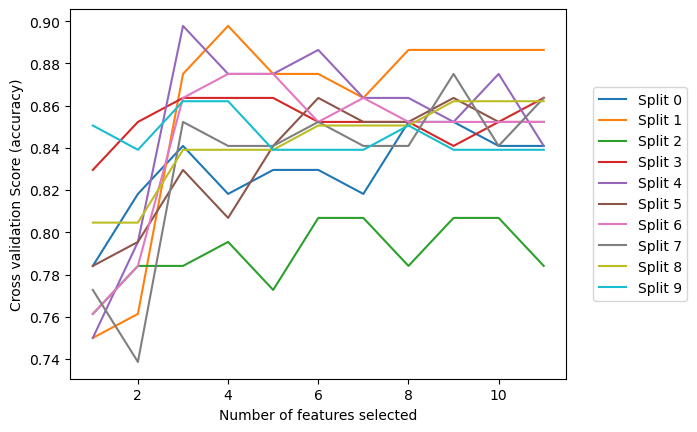

In [35]:
#RFECV
Gradien_Boosting_Classifier = GBC(max_features=0.5, min_samples_split=15, n_estimators=50, max_depth=3, random_state=1945) #Using optimized params
min_features_to_select = 1 
rfecv_2 = RFECV(estimator=Gradien_Boosting_Classifier, step=1, cv=KFold(n_splits=10, random_state=1945, shuffle = True), \
    scoring='accuracy', min_features_to_select=min_features_to_select,)
rfecv_2.fit(X, y)
print('Optimal number of features: %d' % rfecv_2.n_features_)
#Plot
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation Score (accuracy)')
n_splits = 10 
for i in range(n_splits):
    split_score_label = f'split{i}_test_score'
    if split_score_label in rfecv.cv_results_:
        split_scores = rfecv.cv_results_[split_score_label]
        plt.plot(range(min_features_to_select, len(split_scores) + min_features_to_select), split_scores, label=f'Split {i}')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc='center left')
plt.show()

In [36]:
print('RFECV Score:', rfecv_2.score(X, y))


RFECV Score: 0.8986332574031891


In [37]:
print('Feature Rankings:\n')
print(pd.Series(rfecv_2.ranking_, X_names).sort_values())

Feature Rankings:

Number of Escort Ships               1
Number of Stragglers                 1
Total Tons of Convoy                 1
Avg Number of U-Boats in Atlantic    1
Escort Ratio                         1
Time At Sea (Days)                   1
Year                                 1
Previous Month Avg Sink %            1
Approx. Sighting Range               1
Number of Ships                      2
Month                                3
dtype: int64
